# General information

This notebook i made to predict credit scoring in traininf course data science competitions. 

The development time was limited to 48 hours.

# 1. General information

## A description of the fields

- `client_id` - the client identifier

- `app_date` - application submission date

- `education` - level of education

- `sex` - gender of the borrower

- `age` - the age of the borrower

- `car` - flag for car availability

- `car_type` - flag of a foreign car

- `decline_app_cnt` - number of rejected past requests

- `good_work` - flag in the presence of “good” work

- `bki_request_cnt` - number of requests in BKI

- `home_address` - home address categorizer

- `work_address` - categorizer of the work address

- `income` - the borrower's income

- `foreign_passport` - availability of a foreign passport

- `sna` - connection of the borrower with the Bank's clients

- `first_time` - how long ago information about the borrower was available

- `score_bki` - scoring score based on data from BKI

- `region_rating` - ating of the region

- `default` - default flag for the credit

## 1. Initial setup

In [3]:
# importing modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

warnings.filterwarnings('ignore')
%matplotlib inline

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [4]:
# Setting the conditions for experiments

random_seed = 42
current_date = pd.to_datetime('21/10/2020')
pd.set_option('display.max_columns', None)
data_directory = '/kaggle/input/sf-dst-scoring/'
!pip freeze > requirements.txt

In [5]:
# Defining a function for visualization of confusion matrix

def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

# Defining a function for vizualization ROC AUC Plot

def show_roc_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [6]:
# Defining a function for visualization of metrics for logistic regression

def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P, N = np.sum(y_true==1), np.sum(y_true==0)
    TP, TN = np.sum((y_true==1)&(y_pred==1)), np.sum((y_true==0)&(y_pred==0))
    FP, FN = np.sum((y_true==0)&(y_pred==1)), np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df)

## 2. Importing data

In [7]:
# Importing data and quick look

data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
display(data_train.sample(5))
display(data_test.sample(5))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
66388,85762,02APR2014,SCH,M,33,N,N,0,0,-2.728802,0,60,2,3,50000,4,1,N,0
52763,8047,15JAN2014,GRD,F,24,N,N,0,0,-2.954739,0,50,1,2,25000,3,3,N,0
17401,89845,06APR2014,GRD,F,47,Y,Y,0,0,-2.390465,4,80,2,3,250000,1,3,Y,0
33456,79255,27MAR2014,SCH,F,63,N,N,0,0,-2.273060,3,60,2,3,15000,1,4,N,0
62029,4312,10JAN2014,UGR,M,21,N,N,4,1,-1.160431,2,60,1,2,24000,1,2,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
390,88690,05APR2014,GRD,M,47,Y,Y,1,0,-2.115207,1,80,2,3,80000,1,1,N
8954,101896,19APR2014,GRD,F,28,N,N,0,0,-2.290990,1,60,1,2,25000,1,4,N
24937,101215,18APR2014,SCH,F,26,N,N,0,0,-1.690466,3,70,2,3,15000,4,2,N
19464,73600,21MAR2014,SCH,F,34,N,N,0,0,-1.997134,2,50,1,2,22000,2,2,N
7923,60766,10MAR2014,GRD,M,25,N,N,1,0,-1.395007,5,50,2,3,100000,1,3,Y


In [8]:
# Combine the samples for processing

data_train['train'] = 1 # marking the train
data_test['train'] = 0 # marking the test

data = data_train.append(data_test, sort=False).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## 3. Working with attributes

### We see that we have missing values in the 'education' column.

### let's take a closer look

In [9]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

proroption of missing values is: 0.0043
it is less than 0,5%


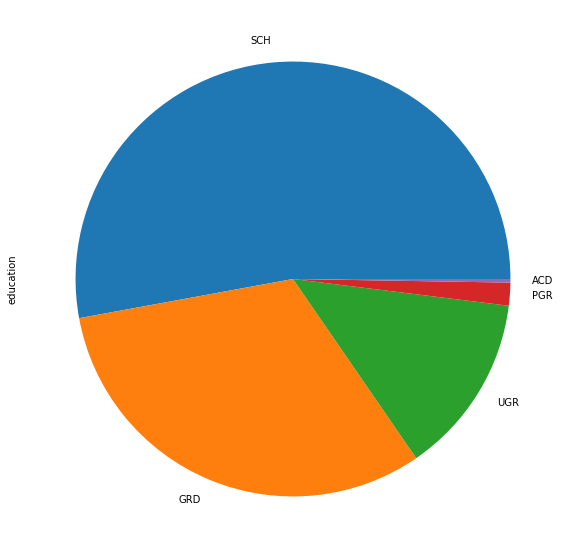

In [10]:
print(f'proroption of missing values is: {data.education.isna().sum() / data.education.shape[0]:.4f}')
print('it is less than 0,5%')
data['education'].value_counts().plot.pie(figsize=(10, 10));

### More than half of the clients have a school education, persentage of missin values is less than 0.05%

### If we replace the missings with the most common values this will not significantly affect the model. Let's do it

In [11]:
# replacing missing values with the most commons

data['education'] = data['education'].fillna('SCH')

### Let's look at the target variable

proportion of clients with default is: 0.1270


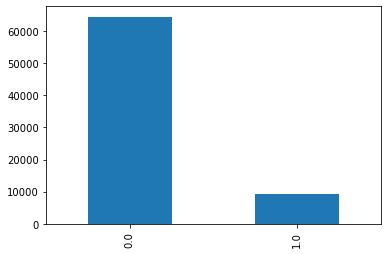

In [12]:
print(f'proportion of clients with default is: {data.default.value_counts()[1] / data.default.value_counts().sum():.4f}')
data.default.value_counts().plot(kind='bar');

### Default clients are almost 7 times less in train data

### Let's look into 'app_date' column and what additional values we can take

In [13]:
print(f'number of unique values: {data.app_date.nunique()}')

number of unique values: 120


In [14]:
# select the day, month, weekend, and season as separate attributes

data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')

data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

# добавим колонку с количеством дней от начала года до запроса

data_min = min(data['app_date'])
data['app_date_timedelta'] = (data['app_date'] - data_min).dt.days.astype('int')

# сезонов в данных всего 2, это будет ограничивать модель, если использовать в будущем

data['weekend'] = data['day'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
season = {1: [12, 1, 2], 2: [3, 4, 5], 3: [6, 7, 8], 4: [9, 10, 11]}
data['season_1'] = data['month'].apply(lambda x: 1 if x in season[1] else 0)
data['season_2'] = data['month'].apply(lambda x: 1 if x in season[2] else 0)

data.drop(['app_date'], axis=1, inplace=True)

### change text data to numeric data using the `sklearn.LabelEncoder()`

In [15]:
for col in data.columns:
    if data[col][0].__class__ == str:
        data[col] = LabelEncoder().fit_transform(data[col])

In [16]:
# all values in column 'client_id' is unique,there's no point in using it in a model

data.shape[0] == data.client_id.nunique()

True

In [17]:
# Let's look at the number of unique values

data.nunique()

client_id             110148
education                  5
sex                        2
age                       52
car                        2
car_type                   2
decline_app_cnt           24
good_work                  2
score_bki             102618
bki_request_cnt           40
region_rating              7
home_address               3
work_address               3
income                  1207
sna                        4
first_time                 4
foreign_passport           2
default                    2
train                      2
day                       31
month                      4
app_date_timedelta       120
weekend                    2
season_1                   2
season_2                   2
dtype: int64

In [18]:
# Defining columns by type

bin_cols = [col for col in data.columns if data[col].nunique() == 2]
bin_cols.remove('default')
bin_cols.remove('train')

cat_cols = ['education', 'region_rating', 'home_address' , 'work_address' , 'day' , 'month']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt', 'income', 'sna', 'first_time', 'app_date_timedelta']

### Let's look at the distribution in the numeric columns. Is it normal or not

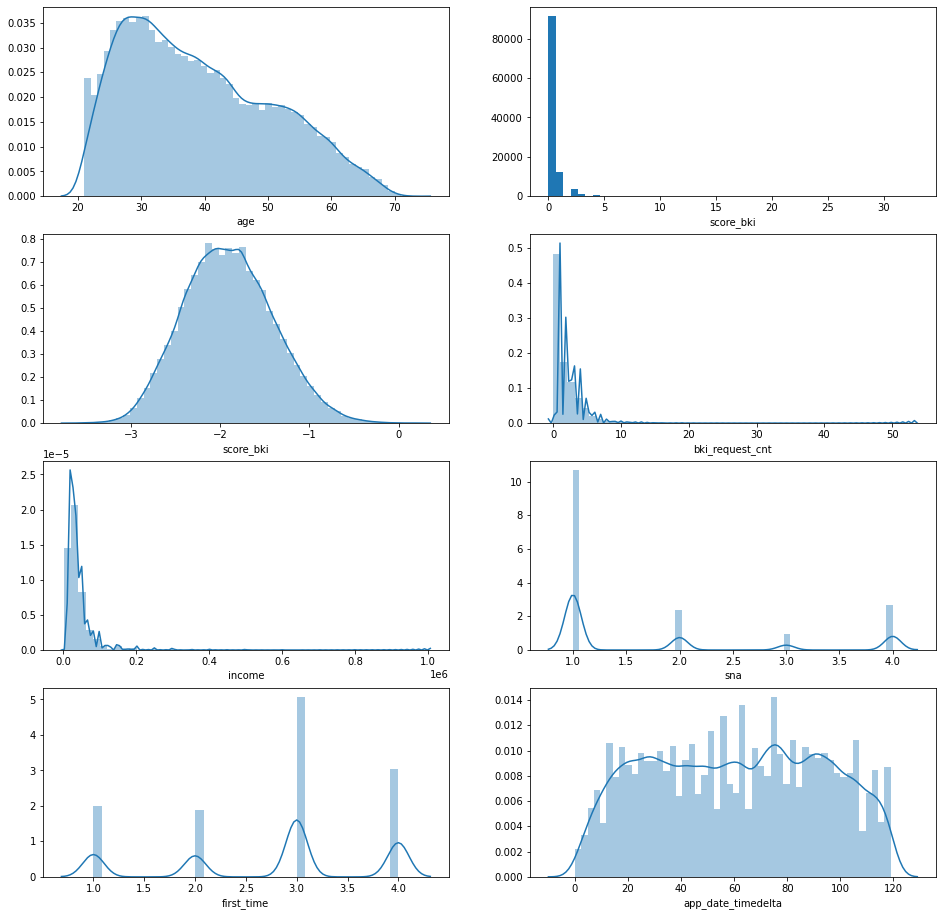

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
sns.distplot(data[num_cols[0]], ax=axs[0][0])
# sns.distplot(data[num_cols[1]], ax=axs[0][1])
axs[0][1].hist(data[num_cols[1]], bins=50)
sns.distplot(data[num_cols[2]], ax=axs[1][0])
sns.distplot(data[num_cols[3]], ax=axs[1][1])
sns.distplot(data[num_cols[4]], ax=axs[2][0])
sns.distplot(data[num_cols[5]], ax=axs[2][1])
sns.distplot(data[num_cols[6]], ax=axs[3][0])
sns.distplot(data[num_cols[7]], ax=axs[3][1]);

axs[0][1].set_xlabel(num_cols[2]);

### Let's normalize numeric attributes and look at them again

In [20]:
# normalizing attributes

data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)

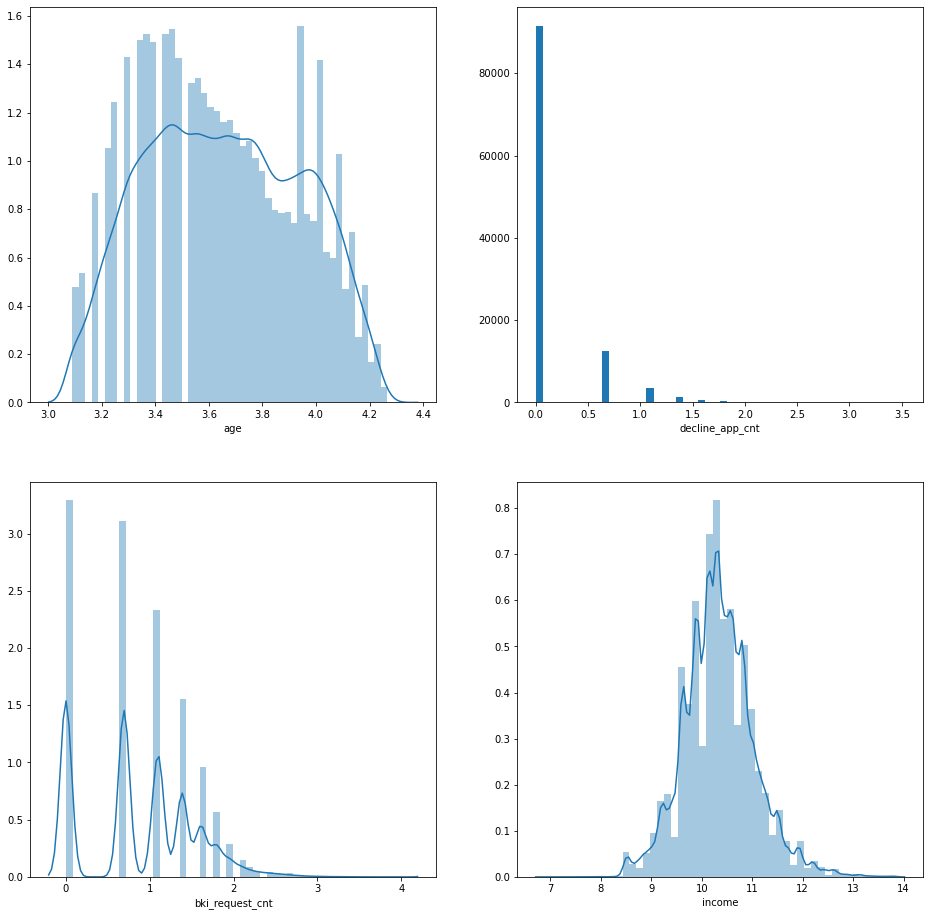

In [21]:
# make a distplots

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
sns.distplot(data['age'], ax=axs[0][0])
axs[0][1].hist(data['decline_app_cnt'], bins=50)
sns.distplot(data['bki_request_cnt'], ax=axs[1][0])
sns.distplot(data['income'], ax=axs[1][1]);

axs[0][1].set_xlabel('decline_app_cnt');

### Now it looks a little bit batter

### Let's standardize them

In [22]:
# standardizing numeric attributes

data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),columns = data[num_cols].columns)

## 4. Feature importance

### let's see how they behave depending on the target variable

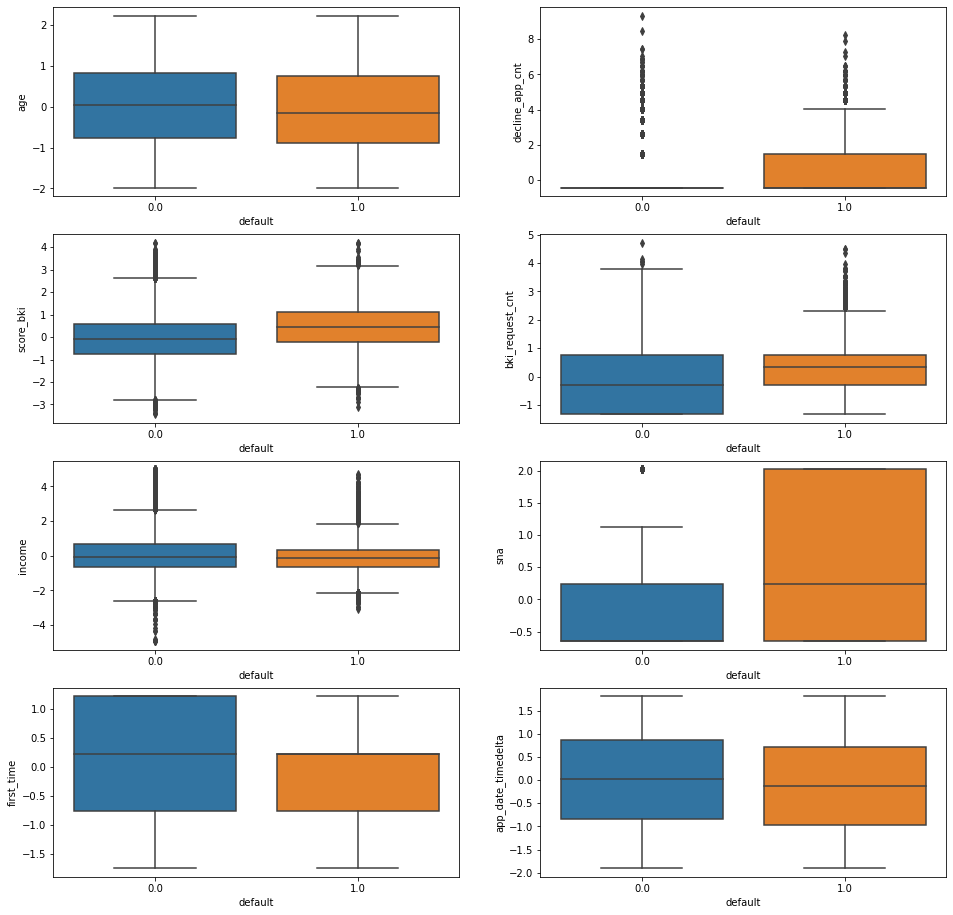

In [23]:
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
sns.boxplot(data.default, data[num_cols[0]], ax=axs[0][0])
sns.boxplot(data.default, data[num_cols[1]], ax=axs[0][1])
sns.boxplot(data.default, data[num_cols[2]], ax=axs[1][0])
sns.boxplot(data.default, data[num_cols[3]], ax=axs[1][1])
sns.boxplot(data.default, data[num_cols[4]], ax=axs[2][0])
sns.boxplot(data.default, data[num_cols[5]], ax=axs[2][1])
sns.boxplot(data.default, data[num_cols[6]], ax=axs[3][0])
sns.boxplot(data.default, data[num_cols[7]], ax=axs[3][1]);

### Let's look at the correlation of numerical features

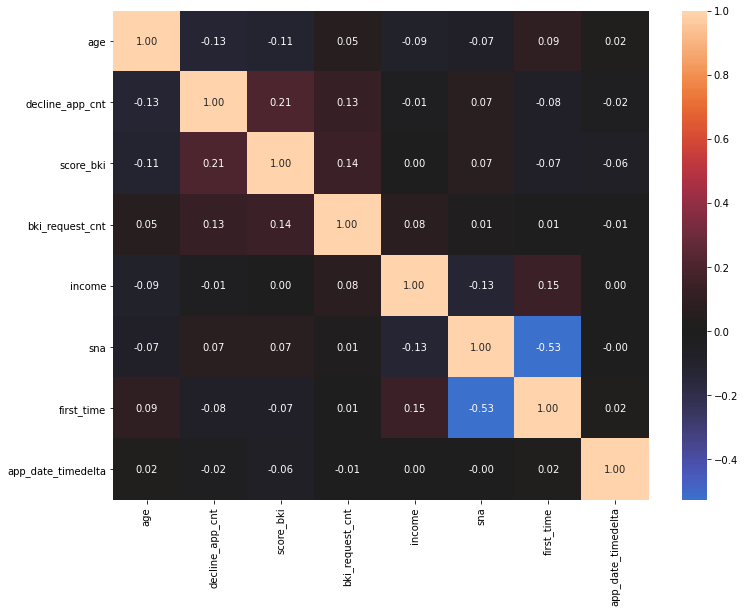

In [24]:
plt.figure(figsize=(12, 9))
sns.heatmap(data[num_cols].corr(), center=0, annot=True, fmt='.2f');

### Let's look at the effect of numeric attributes on the target variable

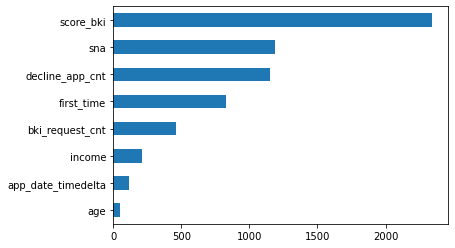

In [25]:
imp_num = pd.Series(f_classif(data[data.train == 1][num_cols], 
                           data[data.train == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### Let's look at the effect of categrical attributes on the target variable

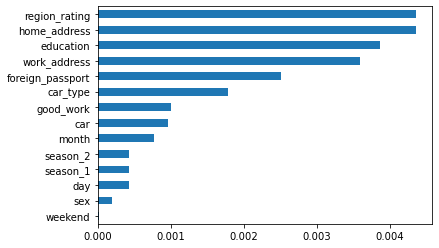

In [26]:
imp_cat = pd.Series(mutual_info_classif(data[data.train == 1][bin_cols + cat_cols], 
                                        data[data.train == 1]['default'],
                                        discrete_features=True), index = bin_cols + cat_cols)


imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

### Let's make One-Hot encoding for categorical features

In [27]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 72 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   sex                 110148 non-null  int64  
 2   age                 110148 non-null  float64
 3   car                 110148 non-null  int64  
 4   car_type            110148 non-null  int64  
 5   decline_app_cnt     110148 non-null  float64
 6   good_work           110148 non-null  int64  
 7   score_bki           110148 non-null  float64
 8   bki_request_cnt     110148 non-null  float64
 9   income              110148 non-null  float64
 10  sna                 110148 non-null  float64
 11  first_time          110148 non-null  float64
 12  foreign_passport    110148 non-null  int64  
 13  default             73799 non-null   float64
 14  train               110148 non-null  int64  
 15  app_date_timedelta  110148 non-nul

## 5. Model

### splitting data for model

In [89]:
train_data = data.query('train == 1').drop(['train', 'client_id'], axis=1)
test_data = data.query('train == 0').drop(['train', 'client_id'], axis=1)
X_test_data = test_data.drop(['default'], axis=1)

train_data = pd.concat([train_data, train_data[train_data.default == 1]], ignore_index=True)

y = train_data.default.values # our target
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# looking what we have now
print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

(36349, 70) (83171, 70) (83171, 69) (66536, 69) (16635, 69)


### Model selection

In [ ]:
# KNeighborsClassifier:
alg_ngbh = KNeighborsClassifier(n_neighbors=5)
alg_ngbh.fit(X_train, y_train)
y_pred_prob = alg_ngbh.predict_proba(X_test)[:,1]
y_pred = alg_ngbh.predict(X_test)
print("roc_auc_score (KNeighborsClassifier):", roc_auc_score(y_test, y_pred_prob))

# GaussianNB:
alg_nbs = GaussianNB()
alg_nbs.fit(X_train, y_train)
y_pred_prob = alg_nbs.predict_proba(X_test)[:,1]
y_pred = alg_nbs.predict(X_test)
print("roc_auc_score (naive bayes):", roc_auc_score(y_test, y_pred_prob))

# LogisticRegression:
alg_log = LogisticRegression(random_state=random_seed, max_iter=200)
alg_log.fit(X_train, y_train)
y_pred_prob = alg_log.predict_proba(X_test)[:,1]
y_pred = alg_log.predict(X_test)
print("roc_auc_score (logistic regression):", roc_auc_score(y_test, y_pred_prob))

# RandomForestClassifier:
alg_frst = RandomForestClassifier(random_state=random_seed, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
alg_frst.fit(X_train, y_train)
y_pred_prob = alg_frst.predict_proba(X_test)[:,1]
y_pred = alg_frst.predict(X_test)
print("roc_auc_score (random forest):", roc_auc_score(y_test, y_pred_prob))

alg_gb = GradientBoostingClassifier(random_state=random_seed)
alg_gb.fit(X_train, y_train)
y_pred_prob = alg_gb.predict_proba(X_test)[:,1]
y_pred = alg_gb.predict(X_test)
print("roc_auc_score (gradient boosting):", roc_auc_score(y_test, y_pred_prob))

### with standard parameters, the logistic regression showed the best result, and we will continue to work with it

In [32]:
# LogisticRegression
model = LogisticRegression(random_state=random_seed, max_iter=200)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

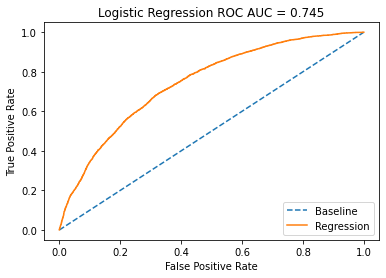

In [33]:
# Plotting the ROC curve

show_roc_auc_curve(y_test, y_pred_prob)

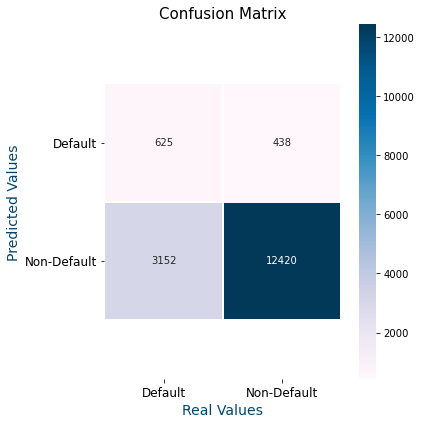

In [34]:
# Checking the confusion matrix

show_confusion_matrix(y_test, y_pred)

In [35]:
# Checking the metrics

all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",3777.000000,default
"Negative, N",12858.000000,non-default
"True Positive, TP",625.000000,correctly identified default
"True Negative, TN",12420.000000,correctly identified non-default
"False Positive, FP",438.000000,incorrectly identified default
"False Negative, FN",3152.000000,incorrectly identified non-default
Accuracy,0.784190,Accuracy=(TP+TN)/(P+N)
Precision,0.587959,Precision = TP/(TP+FP)
Recall,0.165475,Recall = TP/P
F1-score,0.258264,Harmonical mean of Precision и Recall


## 6. Regularization

### Below is an example of how I did regularization, but it didn't bring any tangible improvements, so I decided to leave it as it is for first time, but for second submission I tried to use parameters that i got and my score little beat encreased

In [ ]:
'''
model = LogisticRegression()

grid_params = [{'penalty': ['elasticnet'],
                'C': np.arange(0.1, 20., .1),
                'fit_intercept': [True, False], 
                'class_weight': ['balanced'], 
                'random_state': [random_seed],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                'max_iter': np.arange(100, 600, 100), 
                'l1_ratio': np.arange(0.01, 1., .01)}, 
               {'penalty': ['l1', 'l2'], 
                'C': np.arange(0.1, 20., .1),
                'fit_intercept': [True, False], 
                'class_weight': ['balanced'], 
                'random_state': [random_seed],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                'max_iter': np.arange(100, 600, 100)},
               {'penalty': ['none'], 
                'C': np.arange(0.1, 20., .1),
                'fit_intercept': [True, False], 
                'class_weight': ['balanced'], 
                'random_state': [random_seed],
                'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
                'max_iter': np.arange(100, 600, 100)}]

gridsearch = GridSearchCV(model, grid_params, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_


best_params = model.get_params()
for param in sorted(best_params.keys()):
        print('\t%s: %r' % (param, best_params[param]))

preds = model.predict(X_test)
> print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_preds):.4f}')
'''

### Training Regularized model

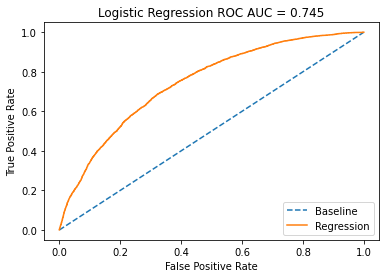

In [91]:
model = LogisticRegression(C = 0.359, class_weight = 'balanced', fit_intercept = True, intercept_scaling = 1,
                           l1_ratio = None, max_iter = 1000, multi_class = 'auto',
                           penalty = 'l1', random_state = random_seed, solver = 'liblinear')

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

show_roc_auc_curve(y_test, y_pred_prob)

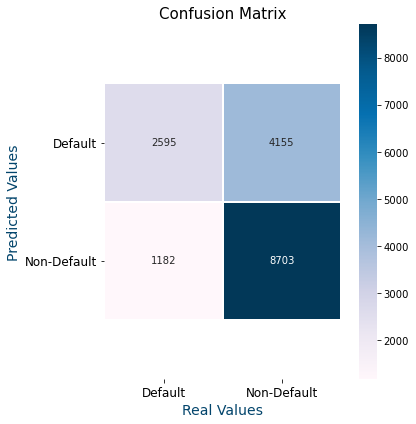

In [92]:
show_confusion_matrix(y_test, y_pred)

In [93]:
all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",3777.000000,default
"Negative, N",12858.000000,non-default
"True Positive, TP",2595.000000,correctly identified default
"True Negative, TN",8703.000000,correctly identified non-default
"False Positive, FP",4155.000000,incorrectly identified default
"False Negative, FN",1182.000000,incorrectly identified non-default
Accuracy,0.679170,Accuracy=(TP+TN)/(P+N)
Precision,0.384444,Precision = TP/(TP+FP)
Recall,0.687053,Recall = TP/P
F1-score,0.493018,Harmonical mean of Precision и Recall


## 7. Submission

In [94]:
y_pred_prob = model.predict_proba(X_test_data)[:,1]

submit = pd.DataFrame(data.query('train == 0')['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission2.csv', index=False)